In [2]:
import sys
import os
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
import sklearn
import itertools

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import qinfer as qi
from scipy import linalg
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import PercentFormatter
import seaborn as sns

from latex_figure import LatexFigure
sys.path.append("/home/bf16951/QMD")
import qmla

In [144]:
probe_dict = qmla.shared_functionality.probe_set_generation.plus_probes_dict(
    num_probes = 2,
    max_num_qubits = 8, 
)
times = np.arange(0, 200, 0.05)
probe = probe_dict[(0,1)]

In [155]:

true_model_params = {
    'pauliSet_1_x_d6' : 0.9, 
    'pauliSet_1_y_d6' : 0.15,
    'pauliSet_1_z_d6' : 0.5,    
    'pauliSet_2_x_d6' : 0.9, 
    'pauliSet_3_y_d6' : 0.15,
    'pauliSet_4_z_d6' : 0.5,    
    'pauliSet_2J3_xJx_d6' : 0.9, 
    'pauliSet_3J5_yJy_d6' : 0.15,
    'pauliSet_4J6_zJz_d6' : 0.5,    
}
n_terms = len(true_model_params)
true_hamiltonian = None
for k in true_model_params: 
    if true_hamiltonian is None: 
        true_hamiltonian = true_model_params[k] * qmla.construct_models.compute(k)
    else:
        true_hamiltonian += true_model_params[k] * qmla.construct_models.compute(k)

test_hamiltonian_params = {
    k : true_model_params[k]*np.random.uniform(0.875, 1.125)
    for k in true_model_params
} # same terms with slightly different params

test_ham = None
for k in test_hamiltonian_params: 
    if test_ham is None: 
        test_ham = test_hamiltonian_params[k] * qmla.construct_models.compute(k)
    else:
        test_ham += test_hamiltonian_params[k] * qmla.construct_models.compute(k)
num_qubits = np.log2(np.shape(true_hamiltonian)[0])
probe = probe_dict[(0,num_qubits)]
frob_norm = np.linalg.norm(true_hamiltonian - test_ham)
norm2 = np.linalg.norm(true_hamiltonian - test_ham, 2)
print("Frobenius norm = ", frob_norm)
print("2-norm = ", norm2)


Frobenius norm =  1.0907660413705182
2-norm =  0.2716286034360538


In [156]:
def loschmidt_echo(
    ham_plus, 
    ham_minus, 
    probe,
    t
):
    H = ham_plus - ham_minus
    U = scipy.linalg.expm(-1j*H*t)
    p1 = np.dot(U, probe)
    p2 = np.dot(probe.T, p1)
    return np.abs(p2)**2

def loschmidt_echo_verbose(
    ham_plus, 
    ham_minus, 
    probe,
    t
):
    
    u1 = scipy.linalg.expm(-1j*ham_plus*t)
    u2 = scipy.linalg.expm(1j*ham_minus*t)
    
    p1 = np.dot(u1, probe)
    p2 = np.dot(u2, p1)
    lik = np.dot(probe.T, p2)
    le = np.abs(lik)**2
    return le

array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
        0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
        0.9 ,  0.95,  1.  ,  1.05,  1.1 ,  1.15,  1.2 ,  1.25,  1.3 ,
        1.35,  1.4 ,  1.45,  1.5 ,  1.55,  1.6 ,  1.65,  1.7 ,  1.75,
        1.8 ,  1.85,  1.9 ,  1.95,  2.  ,  2.05,  2.1 ,  2.15,  2.2 ,
        2.25,  2.3 ,  2.35,  2.4 ,  2.45,  2.5 ,  2.55,  2.6 ,  2.65,
        2.7 ,  2.75,  2.8 ,  2.85,  2.9 ,  2.95,  3.  ,  3.05,  3.1 ,
        3.15,  3.2 ,  3.25,  3.3 ,  3.35,  3.4 ,  3.45,  3.5 ,  3.55,
        3.6 ,  3.65,  3.7 ,  3.75,  3.8 ,  3.85,  3.9 ,  3.95,  4.  ,
        4.05,  4.1 ,  4.15,  4.2 ,  4.25,  4.3 ,  4.35,  4.4 ,  4.45,
        4.5 ,  4.55,  4.6 ,  4.65,  4.7 ,  4.75,  4.8 ,  4.85,  4.9 ,
        4.95,  5.  ,  5.05,  5.1 ,  5.15,  5.2 ,  5.25,  5.3 ,  5.35,
        5.4 ,  5.45,  5.5 ,  5.55,  5.6 ,  5.65,  5.7 ,  5.75,  5.8 ,
        5.85,  5.9 ,  5.95,  6.  ,  6.05,  6.1 ,  6.15,  6.2 ,  6.25,
        6.3 ,  6.35,

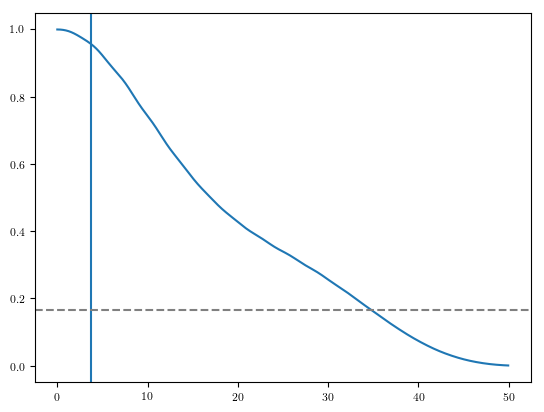

In [161]:
# l1 = np.array([loschmidt_echo(true_hamiltonian, test_ham, probe = probe, t = t) for t in times])
times = times[times < 50]
l2 = np.array([loschmidt_echo_verbose(true_hamiltonian, test_ham, probe = probe, t = t) for t in times])


plt.plot(
    times, 
    l2,
)
first_time_cutoff = 1 / norm2
plt.axvline(first_time_cutoff)

saturation_fidelity = 1 / num_qubits
plt.axhline(saturation_fidelity, ls='--', color='grey')

(0, 1)

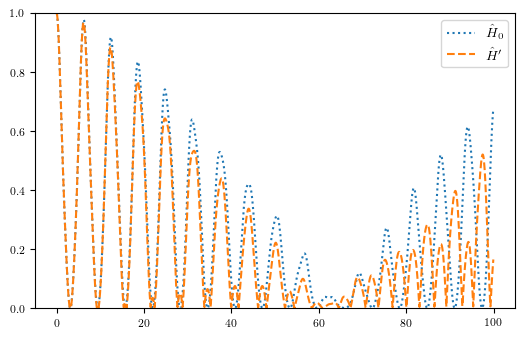

In [138]:
true_likelihoods = [
    qmla.shared_functionality.expectation_values.probability_from_default_expectation_value(
        ham = true_hamiltonian, 
        state = probe,
        t = t
    )
    for t in times
]
test_likelihoods = [
    qmla.shared_functionality.expectation_values.probability_from_default_expectation_value(
        ham = test_ham, 
        state = probe,
        t = t
    )
    for t in times
]


lf = LatexFigure()
ax = lf.new_axis()

ax.plot(
    times, 
    true_likelihoods,
    label=r'$\hat{H}_0$',
    ls=':'
)

ax.plot(
    times, 
    test_likelihoods,
    label=r'$\hat{H}^{\prime}$',
    ls = '--'
)

ax.legend()
ax.set_ylim(0,1)

In [132]:
frob_norm

1.4035100793542556